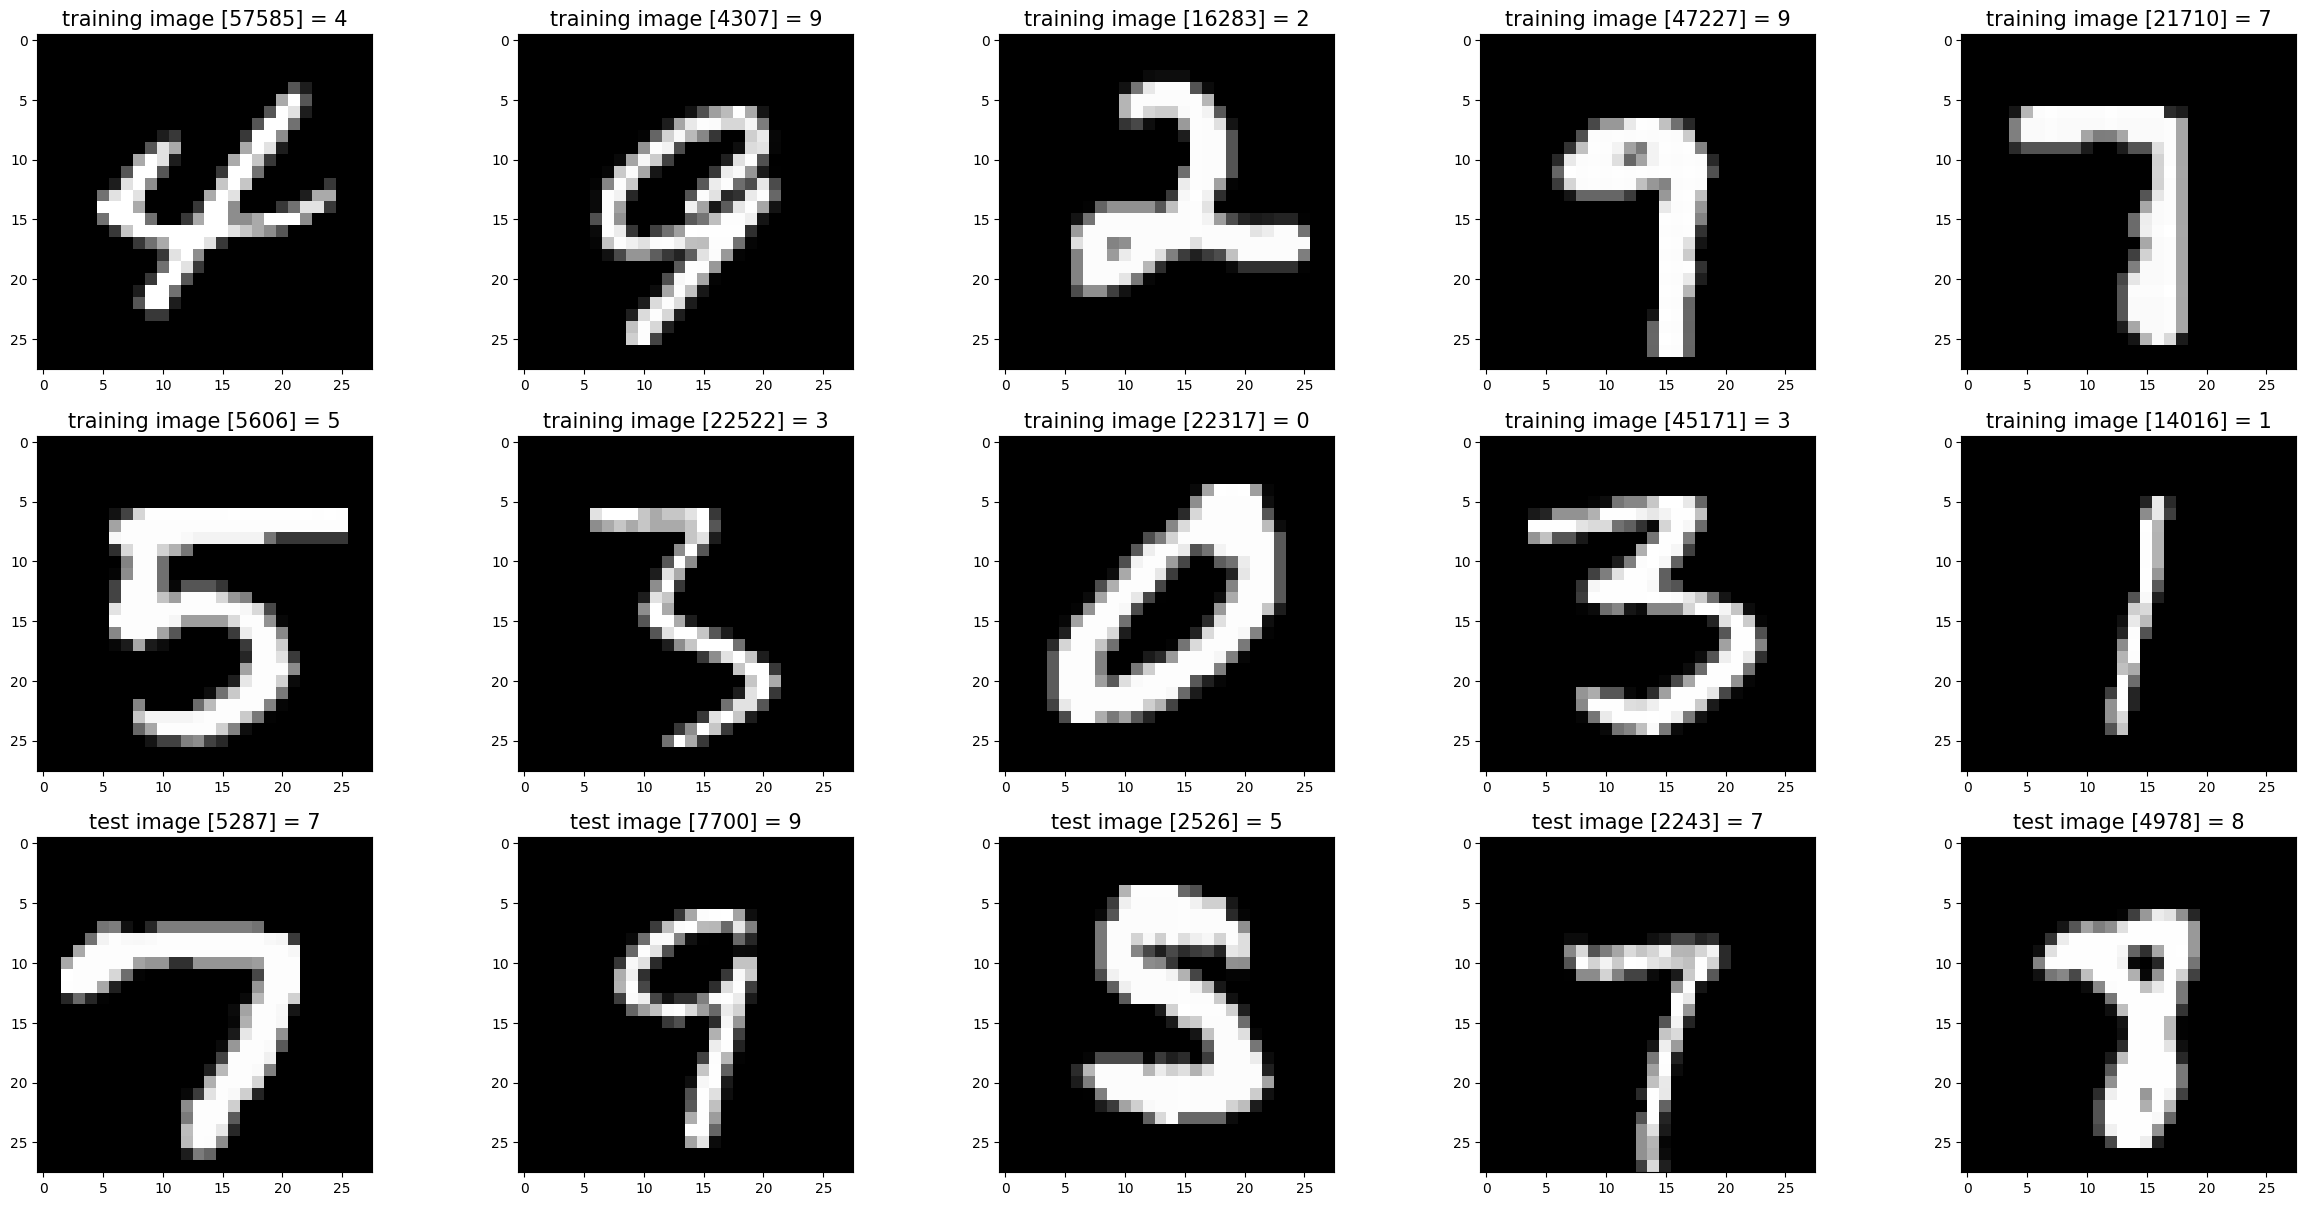

In [1]:
from data_reading import x_train, y_train,x_test, y_test
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, Flatten, MaxPooling2D, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical
import logging
from tensorflow import get_logger

In [2]:

def create_cnn_model(input_shape=(28, 28, 1), num_conv_layers=2, num_filters_per_layer=[32, 64], num_dense_units=128, dropout_rate=0.5):
    """
    Create a CNN model with a variable number of convolutional layers and filters.

    Parameters:
    - input_shape: tuple, the shape of the input images.

    - num_conv_layers: int, the number of convolutional layers.

    - num_filters_per_layer: list of ints, the number of filters in each convolutional layer.

    - num_dense_units: int, the number of units in the dense layer.
    
    - dropout_rate: float, the dropout rate for regularization.

    Returns:
    - model: a Keras model instance.
    """

    model = Sequential()
    
    # Add the convolutional layers
    for i in range(num_conv_layers):
        # For the first layer, specify the input shape
        if i == 0:
            model.add(Conv2D(num_filters_per_layer[i], kernel_size=(3, 3), activation='relu', input_shape=input_shape))
        else:
            model.add(Conv2D(num_filters_per_layer[i], kernel_size=(3, 3), activation='relu'))
        model.add(MaxPooling2D(pool_size=(2, 2)))
    
    model.add(Flatten())
    
    # Add a dense layer
    model.add(Dense(num_dense_units, activation='relu'))
    
    # Add dropout for regularization
    model.add(Dropout(dropout_rate))
    
    # Output layer
    model.add(Dense(10, activation='softmax'))
    
    # Compile the model
    model.compile(optimizer=Adam(), loss='categorical_crossentropy', metrics=['accuracy'])
    
    return model


In [3]:
x_test,x_train = np.array(x_test),np.array(x_train)
y_test,y_train = np.array(y_test),np.array(y_train)

# Reshape the data if necessary
x_train = x_train.reshape(x_train.shape[0], 28, 28, 1)
x_test = x_test.reshape(x_test.shape[0], 28, 28, 1)

# Normalize the data
x_train = x_train.astype('float32') / 255
x_test = x_test.astype('float32') / 255

# One-hot encode the labels
y_train = to_categorical(y_train, num_classes=10)
y_test = to_categorical(y_test, num_classes=10)


In [4]:
model = create_cnn_model(input_shape=(28, 28, 1), num_conv_layers=2, num_filters_per_layer=[32, 64], num_dense_units=128, dropout_rate=0.5)


In [5]:
history = model.fit(x_train, y_train, epochs=10, batch_size=64, validation_split=0.2)


Epoch 1/10
750/750 [==============================] - 21s 26ms/step - loss: 0.2874 - accuracy: 0.9111 - val_loss: 0.0635 - val_accuracy: 0.9807
Epoch 2/10
750/750 [==============================] - 19s 26ms/step - loss: 0.0965 - accuracy: 0.9716 - val_loss: 0.0463 - val_accuracy: 0.9863
Epoch 3/10
750/750 [==============================] - 19s 26ms/step - loss: 0.0713 - accuracy: 0.9791 - val_loss: 0.0435 - val_accuracy: 0.9873
Epoch 4/10
750/750 [==============================] - 20s 27ms/step - loss: 0.0560 - accuracy: 0.9832 - val_loss: 0.0394 - val_accuracy: 0.9892
Epoch 5/10
750/750 [==============================] - 19s 25ms/step - loss: 0.0483 - accuracy: 0.9855 - val_loss: 0.0411 - val_accuracy: 0.9883
Epoch 6/10
750/750 [==============================] - 19s 25ms/step - loss: 0.0388 - accuracy: 0.9876 - val_loss: 0.0373 - val_accuracy: 0.9902
Epoch 7/10
750/750 [==============================] - 25s 33ms/step - loss: 0.0339 - accuracy: 0.9892 - val_loss: 0.0368 - val_accuracy:

In [6]:
test_loss, test_acc = model.evaluate(x_test, y_test)
print(f"Test Accuracy: {test_acc*100:.2f}%")


313/313 [==============================] - 2s 5ms/step - loss: 0.0288 - accuracy: 0.9914
Test Accuracy: 99.14%


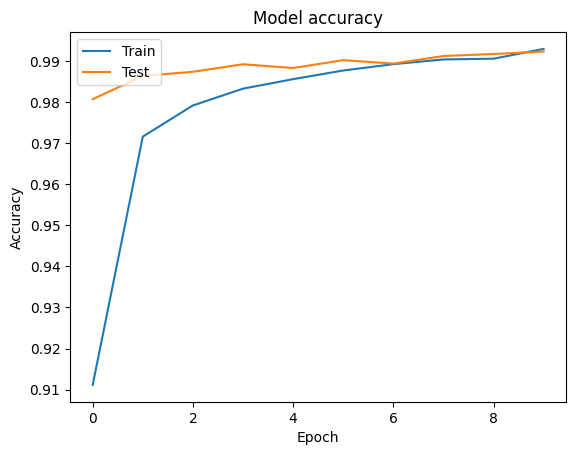

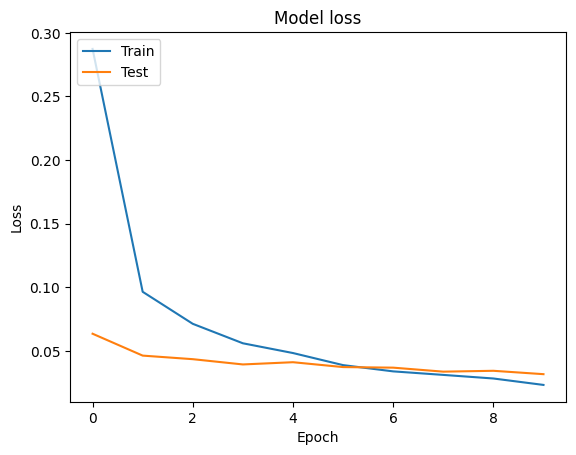

In [7]:
import matplotlib.pyplot as plt

# Plot training & validation accuracy values
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()


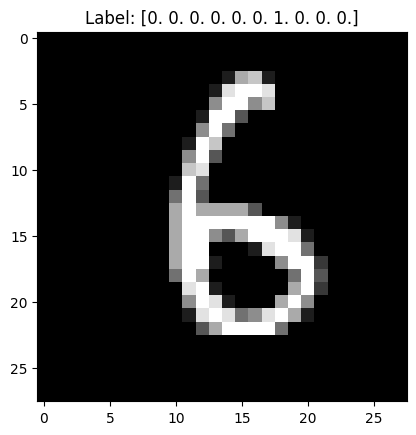

1/1 [==============================] - 0s 256ms/step
Prediction: 6


In [8]:
index = 30*100
plt.imshow(x_test[index].reshape(28, 28), cmap='gray')
plt.title(f'Label: {y_test[index]}')
plt.show()
# Make a prediction on idex variable
prediction = model.predict(x_test[index].reshape(1, 28, 28, 1))
print(f'Prediction: {np.argmax(prediction)}')


In [16]:
import torch

ModuleNotFoundError: No module named 'torch'

In [15]:


def optimize_GP_hyperparams(Xtrain, ytrain, optimization_steps, learning_rate, mean_prior, prior_std):
    '''
    Methods that run the otpimization of the hyperparams of our GP. We will use
    Gradient Descent because it takes to much time to run grid search at each step
    of bayesian optimization. We use a different definition of the kernel to make the
    optimization more stable

    :param X: training set points
    :param y: training targets
    :return: values for lengthscale, output_var, noise_var that maximize the log-likelihood
    '''
    
    # we are re-defining the kernel because we need it in PyTorch
    def squared_exponential_kernel_torch(x, y, _lambda, variance):
        x = x.squeeze(1).expand(x.size(0), y.size(0))
        y = y.squeeze(0).expand(x.size(0), y.size(0))
        sqdist = torch.pow(x - y, 2)
        k = variance * torch.exp(-0.5 * sqdist * (1/_lambda**2))  # NxM
        return k

    X = np.array(Xtrain).reshape(-1,1)
    y = np.array(ytrain).reshape(-1,1)
    N = len(X)

    # tranform our training set in Tensor
    Xtrain_tensor = torch.from_numpy(X).float()
    ytrain_tensor = torch.from_numpy(y ).float()
    # we should define our hyperparameters as torch parameters where we keep track of
    # the operations to get hte gradients from them
    _lambda = nn.Parameter(torch.tensor(1.), requires_grad=True)
    output_variance = nn.Parameter(torch.tensor(1.), requires_grad=True)
    noise_variance = nn.Parameter(torch.tensor(.5), requires_grad=True)

    # we use Adam as optimizer
    optim = torch.optim.Adam([_lambda, output_variance, noise_variance], lr=learning_rate)

    # optimization loop using the log-likelihood that involves the cholesky decomposition 
    nlls = []
    lambdas = []
    output_variances = []
    noise_variances = []
    iterations = optimization_steps
    for i in range(iterations):
        assert noise_variance >= 0, f"ouch! {i, noise_variance}"
        optim.zero_grad()
        K = squared_exponential_kernel_torch(Xtrain_tensor, Xtrain_tensor, _lambda,
                                                output_variance) + noise_variance * torch.eye(N)
        
        L = torch.linalg.cholesky(K)
        _alpha_temp = torch.linalg.solve_triangular(L, ytrain_tensor,upper=False)
        _alpha = torch.linalg.solve_triangular(L.t(),_alpha_temp,upper=True)
        nll = N / 2 * torch.log(torch.tensor(2 * np.pi)) + 0.5 * torch.matmul(ytrain_tensor.transpose(0, 1),
                                                                              _alpha) + torch.sum(torch.log(torch.diag(L)))

        # we have to add the log-likelihood of the prior
        norm = distributions.Normal(loc=mean_prior, scale=prior_std)
        prior_negloglike =  torch.log(_lambda) - norm.log_prob(_lambda)

        nll += 0.9 * prior_negloglike
        nll.backward()

        nlls.append(nll.item())
        lambdas.append(_lambda.item())
        output_variances.append(output_variance.item())
        noise_variances.append(noise_variance.item())
        optim.step()

        # projected in the constraints (lengthscale and output variance should be positive)
        for p in [_lambda, output_variance]:
            p.data.clamp_(min=0.0000001)

        noise_variance.data.clamp_(min=1e-5, max= 0.05)

        
    return _lambda.item(), output_variance.item(), noise_variance.item()

ModuleNotFoundError: No module named 'torch'